In [14]:
from brian2 import *
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import ks_2samp
import pickle
import matplotlib.pyplot as plt

In [15]:
# Estimate individual readout neurons firing rates
def readout_rates(spike_monitor_readout, N_readouts, windowsize):    
    spike_times = spike_monitor_readout['t']
    spike_IDs = spike_monitor_readout['i']

    
    output_rates = np.zeros([N_readouts])
    for k in range(0,len(spike_times)):
        output_rates[spike_IDs[k]] += 1 
    output_rates = output_rates/windowsize
    return output_rates

In [16]:
def pop_rates_in_window(spike_monitor_readout, center, windowsize, N_readouts, t_start,t_stop):
    spike_times = spike_monitor_readout['t']
    spike_IDs = spike_monitor_readout['i']
    idx_t_lower = np.argwhere(spike_times[:] > center - windowsize/2) #find all spikes within lower time bound
    idx_t_start = np.argwhere(spike_times[:] > t_start) #find all spikes after stimulus step change
    idx_t_upper = np.argwhere(spike_times[:] < center + windowsize/2) #find all spikes within upper time bound
    idx = np.intersect1d(idx_t_start, idx_t_lower)
    idx = np.intersect1d(idx, idx_t_upper)
    
    spike_times = spike_times[idx]
    spike_IDs = spike_IDs[idx]
    #adjust window size for egde conditions
    windowsize_temp = np.minimum(center + windowsize/2, t_stop) - np.maximum(center - windowsize/2, t_start)
    pop_output_rate = np.size(spike_IDs)/windowsize_temp

    return pop_output_rate

In [17]:
N_readouts = 400 
objects = []
n_trials = 30
readout_theta_0 = np.linspace(0,1, N_readouts + 1)
readout_theta_0 = readout_theta_0[:-1]
for k in range(0,n_trials):
    with (open('./data/Gaussian_population/data_readout_layer_{}.pickle'.format(k), "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

readout_rates_Gaussian = np.zeros([n_trials,N_readouts])

for k in range(0,n_trials):
    readout_rates_Gaussian[k,:] =  readout_rates(objects[k], N_readouts, 1000*ms) # window size is the entire trial

In [18]:
N_readouts = 400 
objects = []
n_trials = 30
readout_theta_0 = np.linspace(0,1, N_readouts + 1)
readout_theta_0 = readout_theta_0[:-1]
for k in range(0,n_trials):
    with (open('./data/Periodic_population/data_readout_layer_{}.pickle'.format(k), "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

readout_rates_Periodic = np.zeros([n_trials,N_readouts])

for k in range(0,n_trials):        
    readout_rates_Periodic[k,:] =  readout_rates(objects[k], N_readouts, 1000*ms)  # window size is the entire trial 

In [19]:
window_size_pop_rate = 50 * ms
step_size = 1 *ms
n_steps_pop_rate = round((1000*ms)/window_size_pop_rate) 
  
t_pop_rate = np.linspace(0*ms, 1000*ms, n_steps_pop_rate)

In [20]:
N_readouts = 400 
n_trials = 30
# estimate the population firing rate of the readout layer for Gaussian input layer
objects = []
for k in range(0,n_trials):
    with (open('./data/Gaussian_population/data_readout_layer_{}.pickle'.format(k), "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break


population_rate_Gaussian = np.zeros([n_trials, n_steps_pop_rate])

for count, t_center in enumerate(t_pop_rate):
    for k in range(0,n_trials):
        population_rate_Gaussian[k,count] = pop_rates_in_window(objects[k], t_center, window_size_pop_rate, N_readouts, 0*ms, 1000*ms)


# estimate the population firing rate of the readout layer for Periodic input layer        
objects = []

for k in range(0,n_trials):
    with (open('./data/Periodic_population/data_readout_layer_{}.pickle'.format(k), "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

population_rate_Periodic = np.zeros([n_trials, n_steps_pop_rate])

for count, t_center in enumerate(t_pop_rate):
    for k in range(0,n_trials):
        population_rate_Periodic[k,count] = pop_rates_in_window(objects[k], t_center, window_size_pop_rate, N_readouts, 0*ms, 1000*ms)



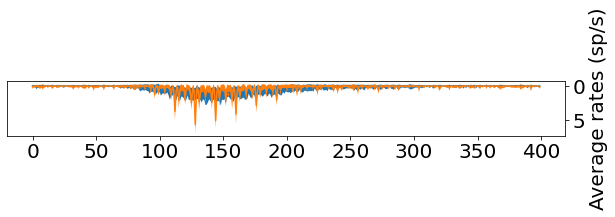

In [21]:
# Plot the individual readout rates
fig, ax = plt.subplots(figsize=(10,1))
plt.rcParams['font.size'] = '20'
mean_readout_rates_Gaussian = np.mean(readout_rates_Gaussian,0)
mean_readout_rates_Gaussian = np.flip(mean_readout_rates_Gaussian)

sd_readout_rates_Gaussian = np.std(readout_rates_Gaussian,0)
sd_readout_rates_Gaussian = np.flip(sd_readout_rates_Gaussian)

mean_readout_rates_Periodic = np.mean(readout_rates_Periodic,0)
mean_readout_rates_Periodic = np.flip(mean_readout_rates_Periodic)

sd_readout_rates_Periodic = np.std(readout_rates_Periodic,0)
sd_readout_rates_Periodic = np.flip(sd_readout_rates_Periodic)

neuron_idx = np.linspace(0,N_readouts - 1, N_readouts)
neuron_idx = np.flip(neuron_idx)

ax.plot(neuron_idx, mean_readout_rates_Gaussian)
ax.fill_between(neuron_idx, mean_readout_rates_Gaussian - sd_readout_rates_Gaussian, mean_readout_rates_Gaussian + sd_readout_rates_Gaussian)
ax.plot(neuron_idx, mean_readout_rates_Periodic)
ax.fill_between(neuron_idx, mean_readout_rates_Periodic - sd_readout_rates_Periodic, mean_readout_rates_Periodic + sd_readout_rates_Periodic)
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.ylabel("Average rates (sp/s)")
plt.savefig('./figures/Readout_rates.png')
plt.savefig('./figures/Readout_rates.eps', format='eps')

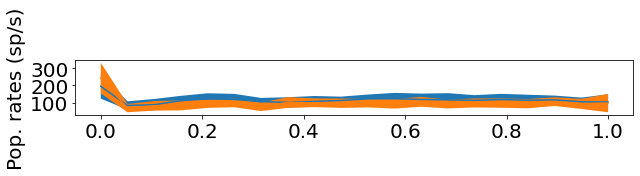

In [22]:
# Plot the readout population rates
fig, ax = plt.subplots(figsize=(10,1))
plt.rcParams['font.size'] = '20'
mean_pop_rate_Gaussian = np.mean(population_rate_Gaussian,0)
sd_pop_rate_Gaussian = np.std(population_rate_Gaussian,0)
mean_pop_rate_Periodic = np.mean(population_rate_Periodic,0)
sd_pop_rate_Periodic = np.std(population_rate_Periodic,0)

ax.plot(t_pop_rate, mean_pop_rate_Gaussian)
ax.fill_between(t_pop_rate, mean_pop_rate_Gaussian - sd_pop_rate_Gaussian, mean_pop_rate_Gaussian + sd_pop_rate_Gaussian)
ax.plot(t_pop_rate, mean_pop_rate_Periodic)
ax.fill_between(t_pop_rate, mean_pop_rate_Periodic - sd_pop_rate_Periodic, mean_pop_rate_Periodic + sd_pop_rate_Periodic)
plt.ylabel("Pop. rates (sp/s)")
plt.savefig('./figures/Readout_population_rates.png')
plt.savefig('./figures/Readout_population_rates.eps', format='eps')